In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import pathlib

from omegaconf import OmegaConf
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from src.utils.visualization import plot_comparison_histogram
from src.utils.evaluation import evaluate

In [3]:
cfg = OmegaConf.load('../config.yaml')

In [4]:
processed_data_dir = '..' / pathlib.Path(cfg.paths.data.processed)
processed_file = processed_data_dir / cfg.files.processed_dataset

df = pd.read_csv(processed_file)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37835 entries, 0 to 37834
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   lat              33608 non-null  float64
 1   long             33608 non-null  float64
 2   download_mbit    37835 non-null  float64
 3   upload_mbit      37835 non-null  float64
 4   ping_ms          37833 non-null  float64
 5   lte_rsrp         23527 non-null  float64
 6   signal_strength  1326 non-null   float64
 7   platform         37835 non-null  object 
 8   network_name     24275 non-null  object 
 9   cat_technology   37835 non-null  object 
dtypes: float64(7), object(3)
memory usage: 2.9+ MB


## Train Test Split

In [6]:
X = df.copy()
y = X.pop(cfg.target)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42)
#X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=1/3, random_state=42)

## Baseline Model

In [7]:
# We define upper limits for download speed
# as thresholds for the baseline model.
# E.g., if download-speed is less than
# 20 mbit/s, we assume its 3G,
# if it is between that and 150 mbit/s
# we say 4G, and beyond that we will return 5G
upper_limits = {
    '3G': 20,
    '4G': 150,
}

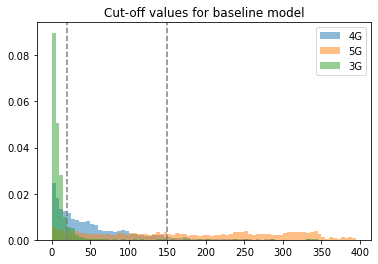

In [8]:
plot_comparison_histogram(
    X_train.download_mbit,
    y_train,
    bins=np.arange(0,400,5),
    vlines=upper_limits.values(),
    title='Cut-off values for baseline model'
)

In [9]:
class BaselineModel:
    def __init__(self, **upper_limits):
        self.upper_limits = upper_limits

    def fit(self, X, y):
        # Upper limits contains 3G and 4G
        # Values above 4G upper limit should be 5G
        # Extract open_category (=5G) by comparing 
        # keys in upper_limits and all available categories
        # in y
        all_categories = set(y.unique())
        covered_categories = set(self.upper_limits.keys())
        open_category = all_categories - covered_categories
        self.open_category = list(open_category)[0]

        # Create series from upper_limits and order
        # descending (highest on top).
        self.ordered_limits = pd.Series(self.upper_limits).sort_values(ascending=False)

    def transform(self, X):
        # Prepare array in length of y
        y_pred = pd.Series(0, index=X.index)
        
        # Values above highest limit are assigned the open
        # category (-> 5G)
        y_pred.loc[X >= self.ordered_limits[0]] = self.open_category
        # Then, iterate through the ordered limits and
        # assign the label if X is smaller than the upper_limit
        for label, limit in self.ordered_limits.iteritems():
            y_pred.loc[X < limit] = label
        
        return y_pred 

    def fit_transform(self, X, y):
        self.fit(X, y)
        result = self.transform(X)

        return result
        
baseline = BaselineModel(**upper_limits)
y_test_baseline = baseline.fit_transform(X_test.download_mbit, y_test)

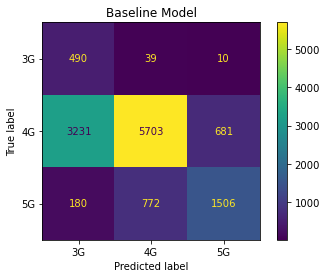

              precision    recall  f1-score   support

          3G       0.13      0.91      0.22       539
          4G       0.88      0.59      0.71      9615
          5G       0.69      0.61      0.65      2458

    accuracy                           0.61     12612
   macro avg       0.56      0.70      0.52     12612
weighted avg       0.81      0.61      0.67     12612

AVG PRECISION: 0.562 (macro)
AVG RECALL: 0.705 (macro)
AVG F1: 0.525 (macro)


In [10]:
evaluate(y_test, y_test_baseline, title='Baseline Model')

## Preprocessing pipeline

In [11]:
# TODO:
# * column transformer pipeline
# * custom transformers for feature generation

## LightGBM Model

In [12]:
# TODO
# sklearn interface
# https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html